In [1]:
#from __future__ import division, print_function
import matplotlib.pyplot as plt
import bilby
import numpy as np

from bilby.core.prior import Uniform
#from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters
%matplotlib inline

import time
import multiprocessing as mp

import hphc5

C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30
Mpc = 3.086*1e22

In [2]:
outdir = 'outdir_new_model'
label = 'create_your_own_source_model'
sampling_frequency = 1024.
duration = 4.

In [3]:
# Here we define our source model - this is the sine-Gaussian model in the
# frequency domain.
def eccentric_waveform(f, mass_1, mass_2, eccentricity, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec):
    
    h_plus = 0*1j
    h_cross = 0*1j
    
    #define the range where the analytic waveformis valid
    fmin = 20.0
    fmax = (C**3)/( G*(mass_1+mass_2)*Mo*np.pi*6**(3/2) )

    if f>=fmin and f<=fmax:        
        arg_plus = {'iota_':theta_jn, 'beta_':psi, 'D_':luminosity_distance , 'm1_':mass_1, 'm2_':mass_2, 'f_':f, 'f0_':20., 'Fp_':1., 'Fc_':0., 'et0_':eccentricity, 'phic_':phase, 'tc_':geocent_time}

        arg_cross = {'iota_':theta_jn, 'beta_':psi, 'D_':luminosity_distance , 'm1_':mass_1, 'm2_':mass_2, 'f_':f, 'f0_':20., 'Fp_':0., 'Fc_':1., 'et0_':eccentricity, 'phic_':phase, 'tc_':geocent_time}

        fplus = hphc5.Fn(**arg_plus)
        h_plus = fplus.htilde()

        fcross = hphc5.Fn(**arg_cross)
        h_cross = fcross.htilde()

    return(h_plus, h_cross)

In [4]:
t0 = time.time()
eccentric_waveform(30, 35.0 ,30.0 , 0.1, 440.0, 0.4, 0.1, 1.2, 1180002601.0, 1.375, -1.2108)
t1 = time.time()
print('Execution took {:.4f}'.format(t1 - t0))

Execution took 0.4053


In [46]:
eccentric_waveform(25, 35.0 ,30.0 , 0.1, 440.0, 0.4, 0.1, 1.2, 1180002601.0, 1.375, -1.2108)

((-8.150061987465542e-23-5.528894817439469e-24j),
 (5.529269253573273e-24-8.150064530932003e-23j))

In [5]:
def multi_run_wrapper(args):
   return eccentric_waveform(*args)

def multicore(f_array, mass_1, mass_2, eccentricity, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec):
    
    arg_list = []
    
    for jj in f_array:
        arg_list.append((jj, mass_1, mass_2, eccentricity, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec))

    result = []
    with mp.Pool(processes=16) as pool:
        result = pool.map(multi_run_wrapper, arg_list)
    
    result = np.array(result)
    h_plus = result[:,0]
    h_cross = result[:,1]
    
    return {'plus': h_plus, 'cross': h_cross}

In [6]:
test_frequency = np.arange(10,10000,1)
t0 = time.time()
data = multicore(test_frequency, 35.0 ,30.0 , 0.1, 440.0, 0.4, 0.1, 1.2, 1180002601.0, 1.375, -1.2108)
t1 = time.time()
print('Execution took {:.4f}'.format(t1 - t0))

Execution took 20.5205


In [39]:
(C**3)/( G*(35.0+30.0)*Mo*np.pi*6**(3/2) )

67.6310005682923

In [71]:
# Set up a random seed for result reproducibility.
np.random.seed(150914)

# We now define some parameters that we will inject
injection_parameters = dict(mass_1=35.0, mass_2=30.0, eccentricity=0.1, luminosity_distance=440.0, theta_jn=0.4, psi=0.1, phase=1.2, geocent_time=1180002601.0, ra=1.375, dec=-1.2108)

# Now we pass our source function to the WaveformGenerator
waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=multicore,
    parameters=injection_parameters)

13:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: __main__.multicore
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [72]:
# Set up interferometers.
minimum_frequency = 20.0+5.0
maximum_frequency = (C**3)/( G*(35.0+30.0)*Mo*np.pi*6**(3/2) )-5.0

ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
for ifo in ifos:
    ifo.minimum_frequency = minimum_frequency
    ifo.maximum_frequency = maximum_frequency
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 2)
ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)

13:36 bilby INFO    : Injected signal in H1:
13:36 bilby INFO    :   optimal SNR = 53.86
13:36 bilby INFO    :   matched filter SNR = 55.39+0.15j
13:36 bilby INFO    :   mass_1 = 35.0
13:36 bilby INFO    :   mass_2 = 30.0
13:36 bilby INFO    :   eccentricity = 0.1
13:36 bilby INFO    :   luminosity_distance = 440.0
13:36 bilby INFO    :   theta_jn = 0.4
13:36 bilby INFO    :   psi = 0.1
13:36 bilby INFO    :   phase = 1.2
13:36 bilby INFO    :   geocent_time = 1180002601.0
13:36 bilby INFO    :   ra = 1.375
13:36 bilby INFO    :   dec = -1.2108
13:36 bilby INFO    : Injected signal in L1:
13:36 bilby INFO    :   optimal SNR = 42.56
13:36 bilby INFO    :   matched filter SNR = 40.97+1.01j
13:36 bilby INFO    :   mass_1 = 35.0
13:36 bilby INFO    :   mass_2 = 30.0
13:36 bilby INFO    :   eccentricity = 0.1
13:36 bilby INFO    :   luminosity_distance = 440.0
13:36 bilby INFO    :   theta_jn = 0.4
13:36 bilby INFO    :   psi = 0.1
13:36 bilby INFO    :   phase = 1.2
13:36 bilby INFO    :  

[{'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

13:36 bilby INFO    : Injected signal in H1:
13:36 bilby INFO    :   optimal SNR = 53.86
13:36 bilby INFO    :   matched filter SNR = 109.24+0.15j
13:36 bilby INFO    :   mass_1 = 35.0
13:36 bilby INFO    :   mass_2 = 30.0
13:36 bilby INFO    :   eccentricity = 0.1
13:36 bilby INFO    :   luminosity_distance = 440.0
13:36 bilby INFO    :   theta_jn = 0.4
13:36 bilby INFO    :   psi = 0.1
13:36 bilby INFO    :   phase = 1.2
13:36 bilby INFO    :   geocent_time = 1180002601.0
13:36 bilby INFO    :   ra = 1.375
13:36 bilby INFO    :   dec = -1.2108
13:36 bilby INFO    : Injected signal in L1:
13:36 bilby INFO    :   optimal SNR = 42.56
13:36 bilby INFO    :   matched filter SNR = 83.53+1.01j
13:36 bilby INFO    :   mass_1 = 35.0
13:36 bilby INFO    :   mass_2 = 30.0
13:36 bilby INFO    :   eccentricity = 0.1
13:36 bilby INFO    :   luminosity_distance = 440.0
13:36 bilby INFO    :   theta_jn = 0.4
13:36 bilby INFO    :   psi = 0.1
13:36 bilby INFO    :   phase = 1.2
13:36 bilby INFO    : 

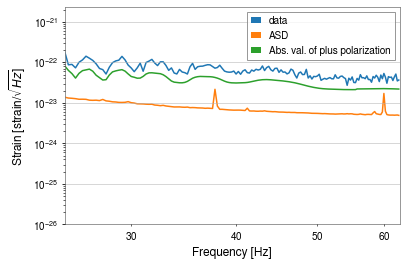

In [73]:
injection = ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)
H1 = ifos[0]
H1_injection = injection[0]

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]),
          label="data")
ax.loglog(H1.frequency_array[idxs],
          H1.amplitude_spectral_density_array[idxs],
          label="ASD")
ax.loglog(H1.frequency_array[idxs],
          np.abs(H1_injection["plus"][idxs]),
          label="Abs. val. of plus polarization")


ax.set_xlim(minimum_frequency,maximum_frequency)
ax.set_ylim(1e-26,2.327737159425905e-21)


ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

In [74]:
#injection_parameters = dict(mass_1=35.0, mass_2=30.0, eccentricity=0.1, luminosity_distance=440.0, 
#theta_jn=0.4, psi=0.1, phase=1.2, geocent_time=1180002601.0, ra=1.375, dec=-1.2108)
priors = bilby.core.prior.PriorDict()
priors["mass_1"] = 35.
priors["mass_2"] = 30.
priors["eccentricity"] = bilby.core.prior.LogUniform(
    name='eccentricity', latex_label='$e$', minimum=0.01, maximum=0.4)
priors["luminosity_distance"] = 440.
priors["theta_jn"] = 0.4
priors["psi"] = 0.1
priors["phase"] = 1.2
priors["geocent_time"] = 1180002601.0
priors["ra"] = 1.375
priors["dec"] = -1.2108

In [75]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator)

In [76]:
result_short = bilby.run_sampler(
    likelihood, priors, sampler='dynesty', outdir='short', label="eccentric_test",
    nlive=500, dlogz=3,  # <- Arguments are used to make things fast - not recommended for general use
    clean=True
)

13:38 bilby INFO    : Running for label 'eccentric_test', output will be saved to 'short'
13:38 bilby INFO    : Using lal version 6.21.0
13:38 bilby INFO    : Using lal git version Branch: None;Tag: lal-v6.21.0;Id: 37caf89936b637993c30b3076fe4b853311873ee;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
13:38 bilby INFO    : Using lalsimulation version 1.10.0
13:38 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v1.10.0;Id: 5bfe091197594d55cf634f8a1c004eb9dc9b6459;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
13:38 bilby INFO    : Search parameters:
13:38 bilby INFO    :   eccentricity = LogUniform(minimum=0.01, maximum=0.4, name='eccentricity', latex_label='$e$', unit=None, boundary=None)
13:38 bilby INFO    :   mass_1 = 35.0
13:38 bilby INFO    :   mass_2 = 30.0
13:38 bilby INFO    :   luminosity_distance = 440.0
13:38 bilby INFO    :   theta_jn = 0.4